# What-if scenarios

In this stage of the analysis, we want to find how changes to the parameters of our model affect the simulated data.

Some areas of interest are:

- How would server utilisation (i.e. resource consumption) be affected by an increase in overall patient arrivals?
- How is the system affected by certain types of patients (e.g. short-stay, low-impact) arriving less frequently?
- What are the sensitivities of mean system times and server utilisation based on a change in $c$?

In [1]:
import itertools as it

from ciw.dists import Exponential
from dask.diagnostics import ProgressBar
from scipy import stats

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")


In [2]:
copd = pd.read_csv("../data/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"])


In [3]:
def get_times(diff):

    times = diff.dt.total_seconds().div(24 * 60 * 60, fill_value=0)
    return times

    
def get_queue_params(data, prop, lambda_coeff, dist=stats.expon):
    """ Get the arrival and service parameters from `data` and the given `prop`. """

    inter_arrivals = (
        data.set_index("admission_date").sort_index().index.to_series().diff()
    )
    interarrival_times = get_times(inter_arrivals)
    lambda_ = lambda_coeff / np.mean(interarrival_times)

    mean_system_time = np.mean(data["true_los"])
    mu_estimate = mean_system_time * prop

    queue_params = {"arrival": lambda_, "service": 1 / mu_estimate}

    return queue_params


@dask.delayed
def simulate_queue(data, column, props, num_servers, seed, max_time, lambda_coeff=1):

    ciw.seed(seed)
    all_queue_params = {}
    for (label, subdata), service_prop in zip(
        data.groupby(column), props
    ):
        all_queue_params[label] = get_queue_params(subdata, service_prop, lambda_coeff)

    N = ciw.create_network(
        arrival_distributions={
            f"Class {label}": [Exponential(params["arrival"])]
            for label, params in all_queue_params.items()
        },
        service_distributions={
            f"Class {label}": [Exponential(params["service"])]
            for label, params in all_queue_params.items()
        },
        number_of_servers=[num_servers],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(max_time)

    return Q


def get_mean_server_utilisation(Q):

    return Q.transitive_nodes[0].server_utilisation


def get_simulation_results(Q, max_time):

    records = Q.get_all_records()
    results = pd.DataFrame(
        [r for r in records if max_time * 0.25 < r.arrival_date < max_time * 0.75]
    )

    results["system_time"] = results["exit_date"] - results["arrival_date"]
    return results[["system_time", "waiting_time", "queue_size_at_arrival", "customer_class"]]


In [4]:
with open("../data/wasserstein/best_params.txt", "r") as f:
    string = f.read()
    *props, num_servers = map(float, string.split(" "))

In [5]:
props, num_servers

([0.9, 1.0, 1.0, 0.5], 45.0)

In [6]:
server_range = range(10, 91)
seeds = 10
max_time = 365 * 3

tasks = (
    simulate_queue(copd, "cluster", props, num_servers, seed, max_time)
    for num_servers, seed in it.product(server_range, range(seeds))
)

with ProgressBar():
    queues = dask.compute(*tasks, scheduler="processes", num_workers=6)

results = [get_simulation_results(Q, max_time) for Q in queues]
utilisations = [get_mean_server_utilisation(Q) for Q in queues]

[########################################] | 100% Completed |  8min 26.7s


Text(0, 0.5, 'Mean server utilisation')

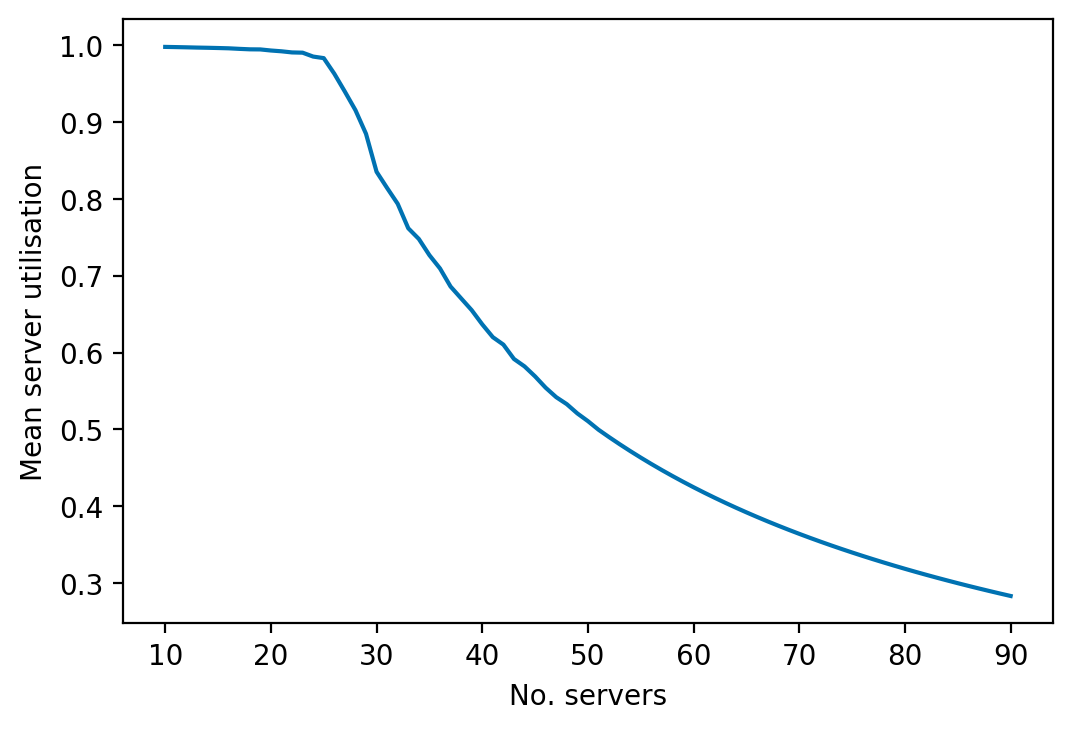

In [7]:
fig, ax = plt.subplots(dpi=200)

ys = np.array(utilisations).reshape(len(utilisations) // seeds, seeds).mean(axis=1)

ax.plot(server_range, ys)

ax.set_xlabel("No. servers")
ax.set_ylabel("Mean server utilisation")

Text(0, 0.5, 'Median system time (days)')

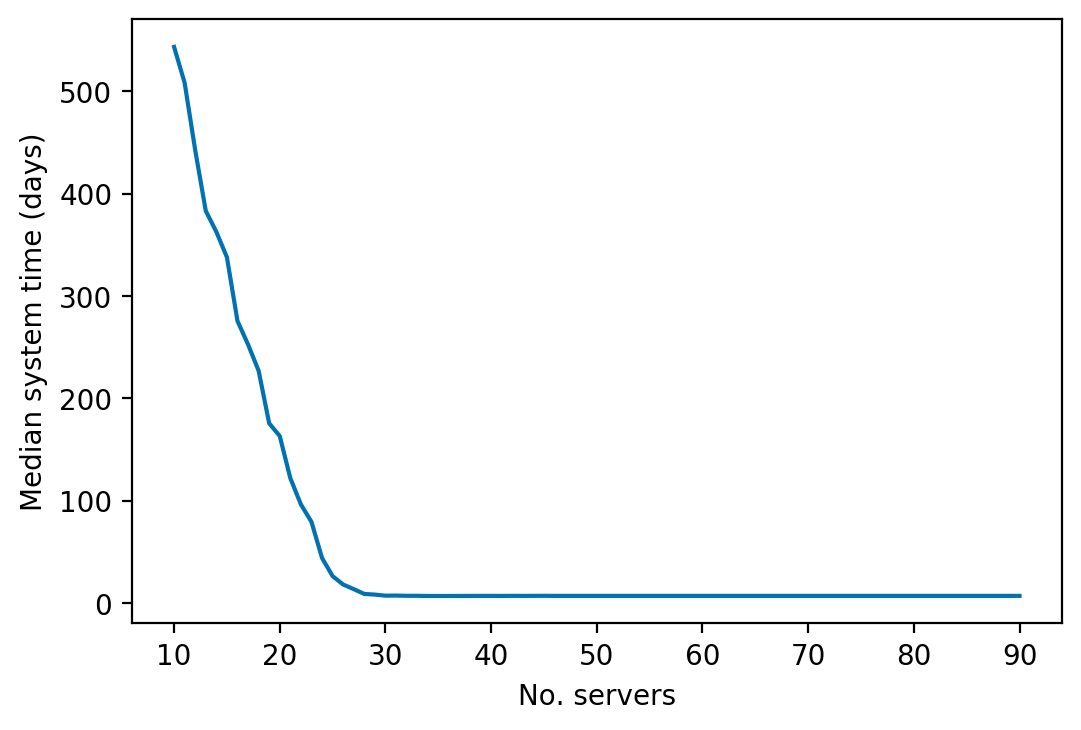

In [24]:
fig, ax = plt.subplots(dpi=200)

system_times = [result["system_time"].mean() for result in results]
ys = np.median(np.array(system_times).reshape(len(system_times) // seeds, seeds), axis=1)

ax.plot(server_range, ys)

ax.set_xlabel("No. servers")
ax.set_ylabel("Median system time (days)")
